# Data Modeling Assignment
***

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Data Reading and Extracting
***

In [17]:
# Reading Dataset
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()

ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns

In [18]:
# Outlier Treatment

for num in numeric:
    Q1 = ground_water_df[num].quantile(0.25)
    Q3 = ground_water_df[num].quantile(0.75)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 -(whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    ground_water_df[num]=np.where(ground_water_df[num]>upper_whisker,upper_whisker,np.where(ground_water_df[num]<lower_whisker,lower_whisker,ground_water_df[num]))

In [19]:
# Standardizing Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ground_water_df[numeric])

ground_water_df[numeric] = scaled_data

ground_water_df[numeric].info()

<class 'pandas.core.frame.DataFrame'>
Index: 817 entries, 0 to 1023
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sno       817 non-null    float64
 1   lat_gis   817 non-null    float64
 2   long_gis  817 non-null    float64
 3   RL_GIS    817 non-null    float64
 4   pH        817 non-null    float64
 5   E.C       817 non-null    float64
 6   TDS       817 non-null    float64
 7   CO3       817 non-null    float64
 8   HCO3      817 non-null    float64
 9   Cl        817 non-null    float64
 10  F         817 non-null    float64
 11  NO3       817 non-null    float64
 12  SO4       817 non-null    float64
 13  Na        817 non-null    float64
 14  K         817 non-null    float64
 15  Ca        817 non-null    float64
 16  Mg        817 non-null    float64
 17  T.H       817 non-null    float64
 18  SAR       817 non-null    float64
 19  RSC       817 non-null    float64
dtypes: float64(20)
memory usage: 134.0 K

In [20]:
# Extracting Chosen Feature to Dataframe
working_gw_df = ground_water_df[['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'mandal', 'village', 'Classification.1']]
working_gw_df = working_gw_df.replace('MR', 'U.S.')

# Changing the Classification.1 to Numeric Valyes (P.S. = 0, U.S. = 1)
le = LabelEncoder()
working_gw_df['Classification.1']= le.fit_transform(working_gw_df['Classification.1']) 

# One-hot encode 'mandal' and 'village' columns separately
mandal_dummies = pd.get_dummies(working_gw_df['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(working_gw_df['village'], prefix='village')

# Concatenate the encoded columns with the original DataFrame
working_gw_df_encoded = pd.concat([working_gw_df.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)

# Display the modified DataFrame
working_gw_df_encoded.head()

,RSC,SAR,Na,E.C,TDS,HCO3,pH,Classification.1,mandal_Abdullapurmet,mandal_Achampet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-0.585459,-0.280348,-0.183791,-0.006796,-0.005646,-0.157500,0.558173,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.496198,-1.025176,-1.198847,-1.738824,-1.739070,-1.777157,0.959698,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.494650,0.665784,0.287996,-0.227203,-0.226629,0.780196,0.440077,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.579402,0.196073,0.087844,-0.074755,-0.074524,0.353971,0.487315,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.003028,-0.300479,-0.198087,0.075856,0.074711,0.439216,0.723507,0,False,False,...,False,False,False,False,False,False,False,False,False,False


# Logistic Regression
referenced: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8, 
https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

***

In [21]:
# Splitting Data
X = working_gw_df_encoded.drop(['Classification.1'], axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [ ]:
# parameter finetuning with grid search
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_res, y_train_res)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.998893 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998893 (0.003321) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998893 (0.003321) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.998893 (0.003321) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.998523 (0.003767) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998523 (0.003767) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.996671 (0.005086) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.995564 (0.006130) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.995564 (0.006130) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.992975 (0.007286) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.991127 (0.008300) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.991127 (0.008300) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.977827 (0.018350) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.959723 (0.022832) wit

In [22]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train_res)

In [23]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy of Logistic Regression classifier: {:.2f}'.format(accuracy))

Accuracy of Logistic Regression classifier: 0.99


Correctly Classified: 325
Incorrectly Classified: 2


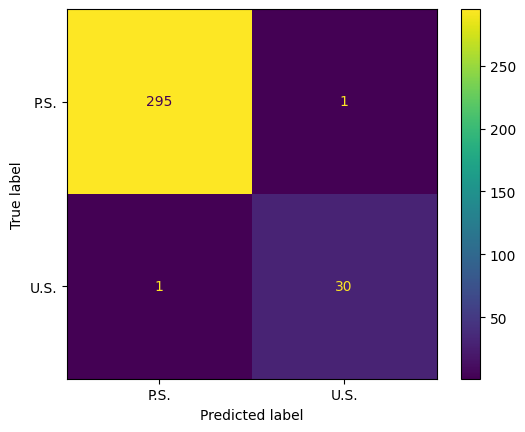

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['P.S.', 'U.S.'])
disp.plot().figure_.savefig('LOG_CM.png')
correct = cm[0][0] + cm[1][1]
incorrect = cm[0][1] + cm [1][0]
print('Correctly Classified:', correct)
print('Incorrectly Classified:', incorrect)

In [25]:
# Classification Report
print(classification_report(y_test, y_pred_test))
print(classification_report(y_train_res, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       0.97      0.97      0.97        31

    accuracy                           0.99       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.99      0.99      0.99       327

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       454
           1       1.00      1.00      1.00       454

    accuracy                           1.00       908
   macro avg       1.00      1.00      1.00       908
weighted avg       1.00      1.00      1.00       908



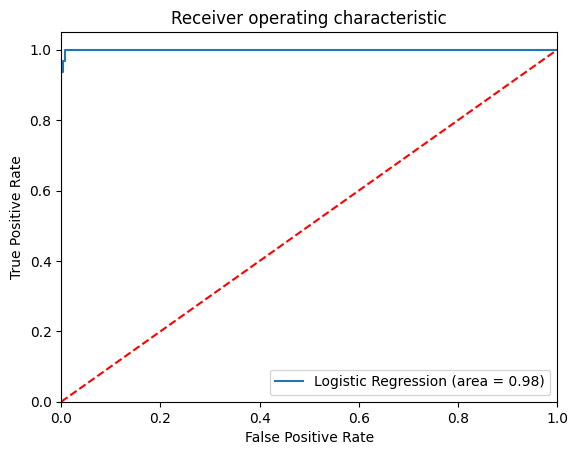

In [26]:
# ROC Curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()